In [1]:
%env DATA_DIR=$HOME/datasets
%env EXPERIMENT_BASE=$HOME/experiments/ood_flows
%env LOG_LEVEL=INFO
%env BATCH_SIZE=64
%env OPTIM_LR=0.001
%env OPTIM_M=0.8
%env TRAIN_EPOCHS=100
%env EXC_RESUME=1
%env DATASET_NAME=S_QPM_species
%env MANIFOLD_D=512
%env MODEL_NAME=resnet50_ssl
# %env OOD_K=4

env: DATA_DIR=$HOME/datasets
env: EXPERIMENT_BASE=$HOME/experiments/ood_flows
env: LOG_LEVEL=INFO
env: BATCH_SIZE=64
env: OPTIM_LR=0.001
env: OPTIM_M=0.8
env: TRAIN_EPOCHS=100
env: EXC_RESUME=1
env: DATASET_NAME=S_QPM_species
env: MANIFOLD_D=512
env: MODEL_NAME=resnet50_ssl


In [2]:
import lightning.pytorch as pl
import numpy as np
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger

from config import Config, load_config
from datasets import get_data
from models import get_model

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

config = load_config()

In [4]:
# initialize data attributes and loaders
config.load_data()
config.print_labels()
dm = config.datamodule
assert dm

In [5]:
dm.setup("test")

Dataset type train label type: species
Loaded 375443 images
Dataset type val label type: species
Loaded 48562 images
Dataset type test label type: species
Loaded 48790 images
Performing ind/ood split


100%|██████████| 375443/375443 [03:17<00:00, 1905.17it/s]


Train - OK


100%|██████████| 48562/48562 [00:25<00:00, 1921.93it/s]


Val - OK


100%|██████████| 48790/48790 [00:09<00:00, 5011.35it/s]

Test - OK
Performed ind/ood split
375443 48562 48790 0


In [6]:
model = config.get_model()

In [7]:
model_id = "sqmx5s1i"

In [9]:
from pathlib import Path
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/uq_project/model-{model_id}:best")
model = model.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-sqmx5s1i:best, 302.52MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [10]:
test_loader = dm.test_dataloader()

In [65]:
from models.common import edl_probs
from tqdm.auto import tqdm

embeddings = []
labels = []

for batch_idx, batch in enumerate(tqdm(test_loader)):
    (xa, xb), y = batch
    xa = xa.float().cuda()
    xb = xb.float().cuda()
    y = y.long().cpu()
    proj_a, proj_b, logits = model(xa)
    embedding = proj_a.detach().flatten(start_dim=1).cpu().numpy()
    embeddings.extend(embedding)
    labels.extend(y.detach().numpy())
print("OK")

100%|██████████| 763/763 [00:06<00:00, 115.73it/s]


OK


In [70]:
embeddings = np.array(embeddings)
labels = np.array(labels)
print(embeddings.shape)
print(labels.shape)

(48790, 1024)
(48790,)


In [72]:
perm = np.arange(labels.shape[0])
np.random.shuffle(perm)

N = 1000
perm = perm[:V]
print(perm.shape)

(1000,)


In [80]:
from sklearn.manifold import TSNE

tsne_emb = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings[perm])
print(tsne_emb.shape)

(1000, 2)


AttributeError: PathCollection.set() got an unexpected keyword argument 'figsize'

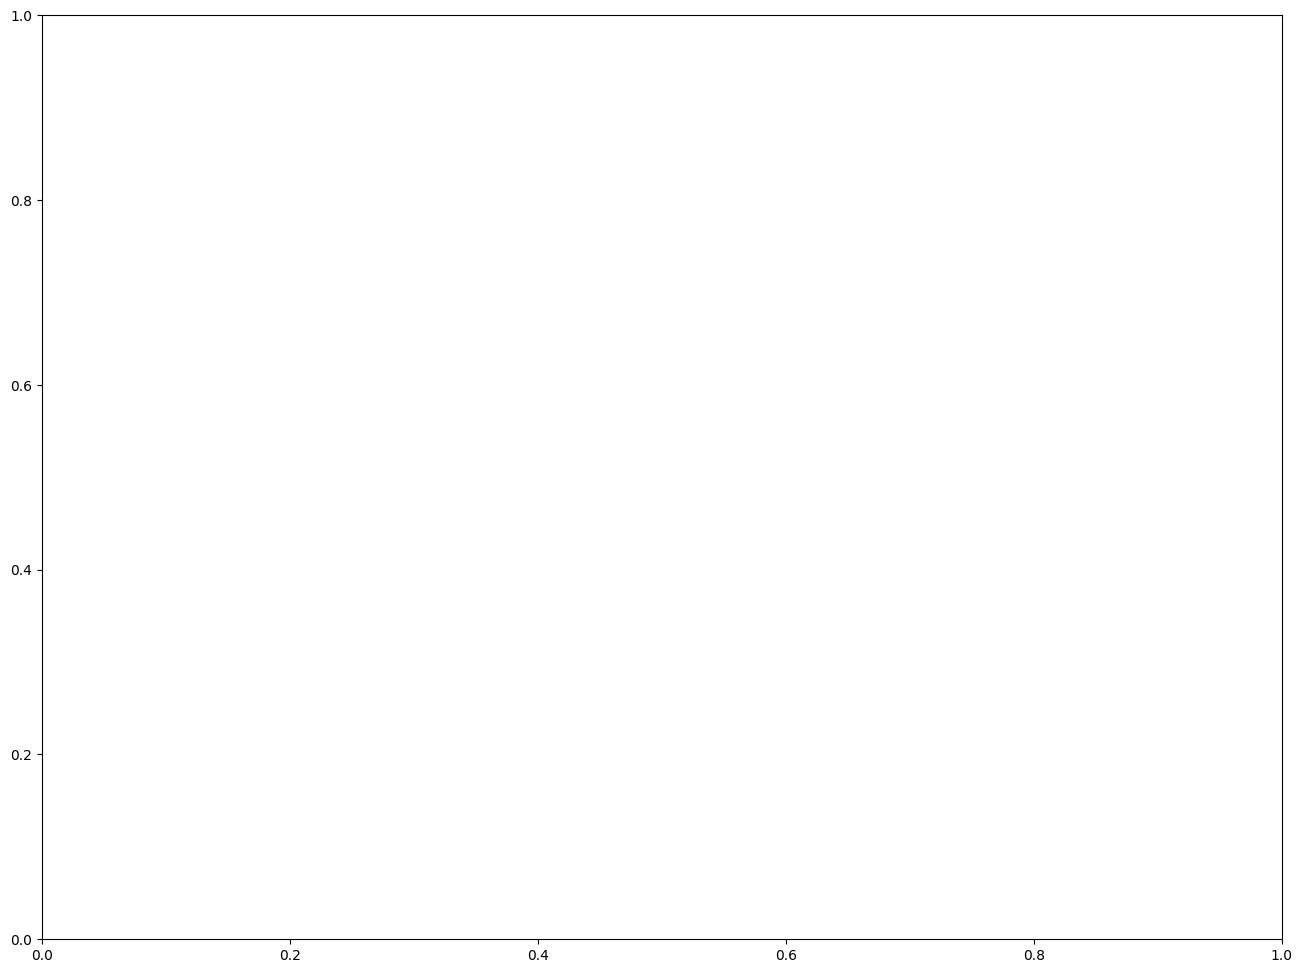

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns

x, y = tsne_emb.T
c = [config.labels[i] for i in labels[perm]]
data = pd.DataFrame(dict(x=x, y=y, c=c))
sns.scatterplot(data=data, x="x", y="y", hue="c", figsize=(10,10))